In [1]:
import sys
import os

# Get the parent directory of the current notebook directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from gbp.gbp import *
from gbp.factor import *
from gbp.grid import *
import matplotlib.pyplot as plt

Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/home/yuzhou/anaconda3/envs/jax-gpu/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 420, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yuzhou/anaconda3/envs/jax-gpu/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", li

In [2]:
H = 16
W = 16
prior_noise_std=prior_std=1
odom_noise_std=odom_std=0.01
seed=0
r=2


positions, prior_meas, between_meas = generate_grid_slam_data(H=H, W=W, 
                                    prior_noise_std=prior_noise_std, odom_noise_std=odom_noise_std, seed=seed)

#prior_meas = [(i, [0, 0]) for i, _ in prior_meas]

varis, prior_facs, between_facs = build_pose_slam_graph(N=256, prior_meas=prior_meas, between_meas=between_meas, 
                                                        prior_std=prior_std, odom_std=odom_std,
                                                        Ni_v=10, D=2)


# build the coarse-level pose SLAM grid
varis_sup, prior_facs_sup, horizontal_facs_sup, vertical_facs_sup  = build_coarse_slam_graph(
    prior_facs_fine=prior_facs,
    between_facs_fine=between_facs,
    H=H, W=W,
    stride = 2,
)


# Variable update
varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

# Unary factor Update
prior_facs, varis_sup = update_factor(prior_facs_sup, varis_sup, vtof_msgs, linpoints, h3_fn, l2)

# Variable update
varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)


# Binary factor update
horizontal_facs_sup, varis_sup = update_factor(horizontal_facs_sup, varis_sup, vtof_msgs, 
                                                linpoints, h4_fn, l2)

vertical_facs_sup, varis_sup = update_factor(vertical_facs_sup, varis_sup, vtof_msgs, 
                                                linpoints, h5_fn, l2)


# Variable update
varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
sup_iterations = 0  # Number of iterations for the abstraction recovery

for i in range(sup_iterations):
    # Unary factor Update
    prior_facs, varis_sup = update_factor(prior_facs_sup, varis_sup, vtof_msgs, linpoints, h3_fn, l2)
    # Binary factor update
    horizontal_facs_sup, varis_sup = update_factor(horizontal_facs_sup, varis_sup, vtof_msgs, 
                                                    linpoints, h4_fn, l2)
    vertical_facs_sup, varis_sup = update_factor(vertical_facs_sup, varis_sup, vtof_msgs, 
                                                    linpoints, h5_fn, l2)

    # Variable update
    varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

In [4]:
varis_abs, prior_facs_abs, horizontal_facs_abs, vertical_facs_abs, Bs, ks = build_abs_slam_graph(
    varis_sup=varis_sup,
    prior_facs_sup=prior_facs_sup,
    horizontal_facs_sup=horizontal_facs_sup,
    vertical_facs_sup=vertical_facs_sup,
    r=r)

# Step 1: Variable update
varis_abs, vtof_msgs, linpoints = update_variable(varis_abs)

# Factor update
prior_facs_abs, varis_abs = update_factor_tilde(prior_facs_abs, varis_abs, vtof_msgs, linpoints, Bs, ks, h3_fn_tilde, l2)


varis_abs, vtof_msgs, linpoints = update_variable(varis_abs)


# Factor update
horizontal_facs_abs, varis_abs = update_factor_tilde(horizontal_facs_abs, varis_abs, vtof_msgs, 
                                                linpoints, Bs, ks, h4_fn_tilde, l2)

vertical_facs_abs, varis_abs = update_factor_tilde(vertical_facs_abs, varis_abs, vtof_msgs, 
                                                linpoints, Bs, ks, h5_fn_tilde, l2)

# Variable update
varis_abs, vtof_msgs, linpoints = update_variable(varis_abs)



In [5]:
for i in range(1000):
    # Factor update
    prior_facs_abs, varis_abs = update_factor_tilde(prior_facs_abs, varis_abs, vtof_msgs, linpoints, Bs, ks, h3_fn_tilde, l2)

    horizontal_facs_abs, varis_abs = update_factor_tilde(horizontal_facs_abs, varis_abs, vtof_msgs, 
                                                linpoints, Bs, ks, h4_fn_tilde, l2)

    vertical_facs_abs, varis_abs = update_factor_tilde(vertical_facs_abs, varis_abs, vtof_msgs, 
                                                linpoints, Bs, ks, h5_fn_tilde, l2)

    # Variable update 
    varis_abs, vtof_msgs, linpoints = update_variable(varis_abs)

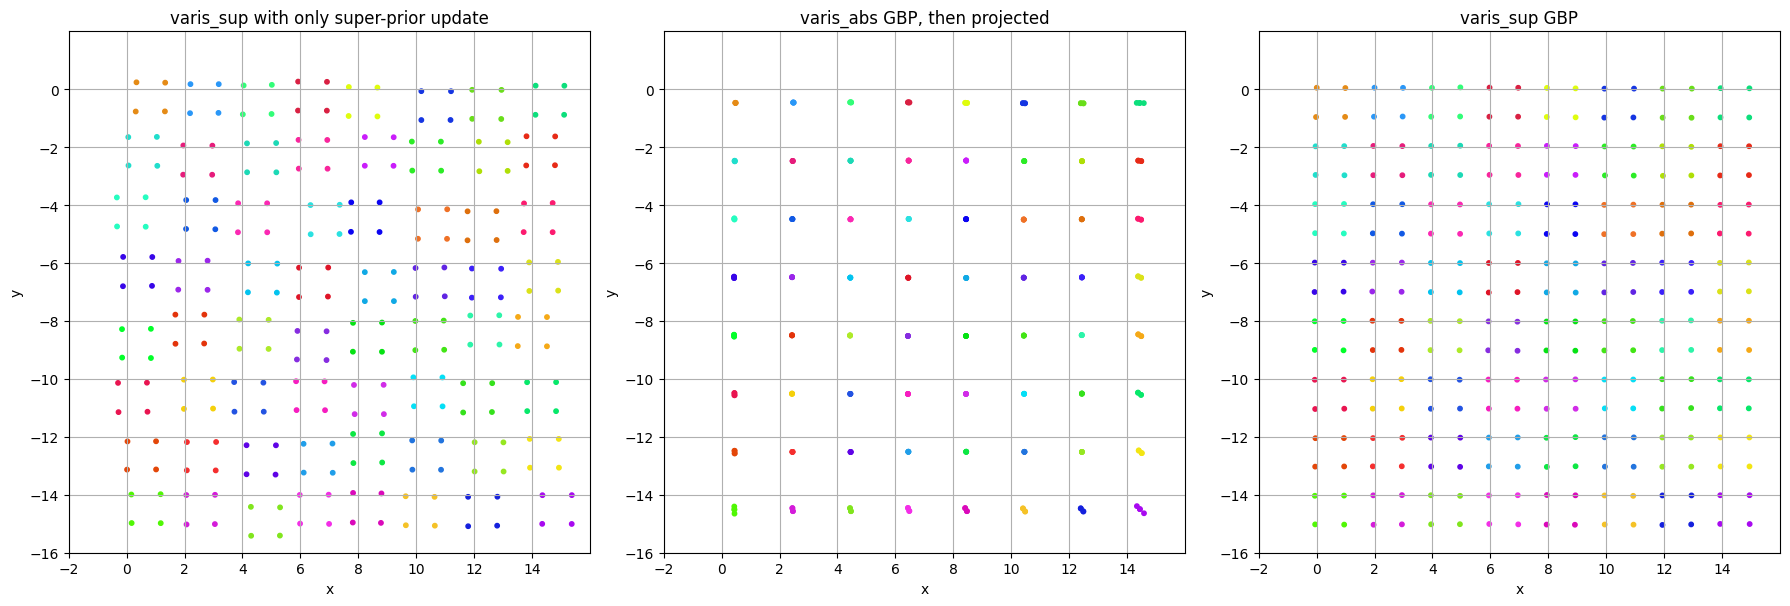

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import colorsys
import random

# Get initial mu_sup (original belief)
a = varis_sup.belief.mu().reshape(64, 4, 2).reshape(-1, 2)

# Projected mu_sup from varis_abs
mu_abs = varis_abs.belief.mu()
mu_sup = []
for i in range(len(mu_abs)):
    points = Bs[i] @ mu_abs[i] #+ ks[i]  # shape (8,)
    mu_sup.append(points[0:2])
    mu_sup.append(points[2:4])
    mu_sup.append(points[4:6])
    mu_sup.append(points[6:8])
mu_sup = jnp.stack(mu_sup)  # shape (256, 2)

# Generate 64 vivid random RGB colors
def generate_random_vivid_colors(n):
    hsv_colors = [(i / n, random.uniform(0.8, 1.0), random.uniform(0.85, 1.0)) for i in range(n)]
    np.random.shuffle(hsv_colors)
    rgb_colors = [colorsys.hsv_to_rgb(*hsv) for hsv in hsv_colors]
    return rgb_colors

colors = generate_random_vivid_colors(64)
point_colors = np.repeat(colors, 4, axis=0)

# -------- Run super node update with separate variables --------
import copy
varis_sup_b = copy.deepcopy(varis_sup)
prior_facs_sup_b = copy.deepcopy(prior_facs_sup)
horizontal_facs_sup_b = copy.deepcopy(horizontal_facs_sup)
vertical_facs_sup_b = copy.deepcopy(vertical_facs_sup)

sup_iterations = 1000
for i in range(sup_iterations):
    varis_sup_b, vtof_msgs_b, linpoints_b = update_variable(varis_sup_b)
    prior_facs_sup_b, varis_sup_b = update_factor(prior_facs_sup_b, varis_sup_b, vtof_msgs_b, linpoints_b, h3_fn, l2)
    horizontal_facs_sup_b, varis_sup_b = update_factor(horizontal_facs_sup_b, varis_sup_b, vtof_msgs_b, linpoints_b, h4_fn, l2)
    vertical_facs_sup_b, varis_sup_b = update_factor(vertical_facs_sup_b, varis_sup_b, vtof_msgs_b, linpoints_b, h5_fn, l2)
    varis_sup_b, vtof_msgs_b, linpoints_b = update_variable(varis_sup_b)

# Get updated mu_sup belief (after GBP)
b = varis_sup_b.belief.mu().reshape(64, 4, 2).reshape(-1, 2)

# -------- Plotting 3 subplots side by side --------
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].scatter(a[:, 0], a[:, 1], c=point_colors, s=10)
axs[0].set_title("varis_sup with only super-prior update")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

axs[1].scatter(mu_sup[:, 0], mu_sup[:, 1], c=point_colors, s=10)
axs[1].set_title("varis_abs GBP, then projected")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

axs[2].scatter(b[:, 0], b[:, 1], c=point_colors, s=10)
axs[2].set_title("varis_sup GBP")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")

for ax in axs:
    ax.set_xlim(-2, 16)
    ax.set_ylim(-16, 2)
    ax.set_xticks(range(-2, 16, 2))
    ax.set_yticks(range(-16, 2, 2))
    ax.grid(True)
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig("comparison_three_subplots.png", dpi=400)


In [7]:
average_position_error = 0
for i in range(256):
    average_position_error += np.linalg.norm(mu_sup[i]-b[i])

average_position_error /=256
print(average_position_error)


0.6988164682406932


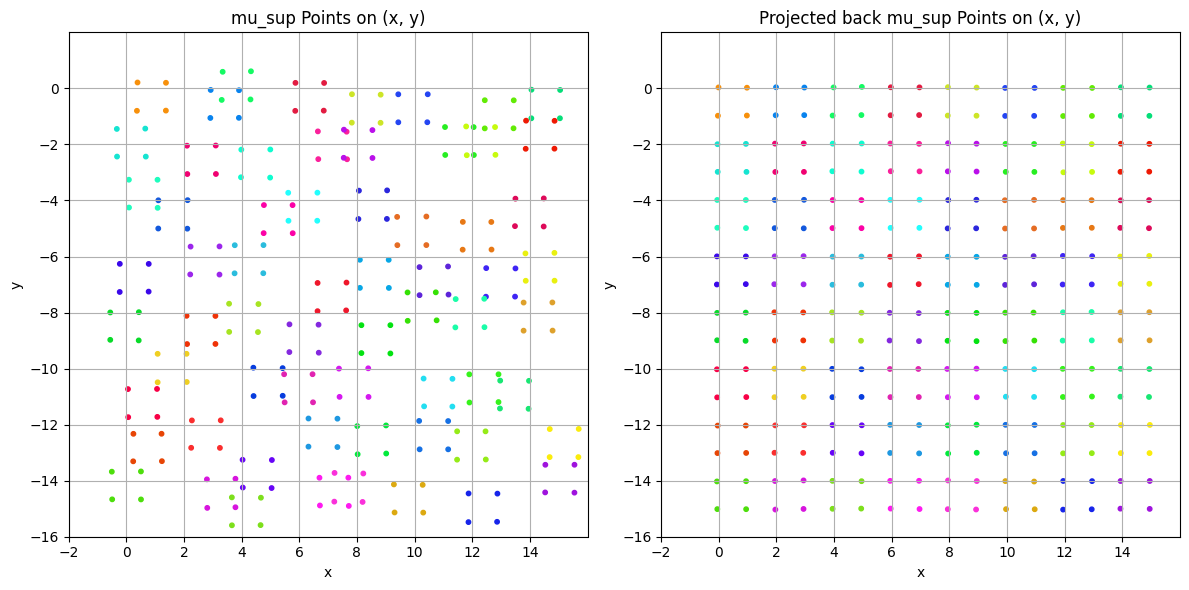

In [878]:
import random
import colorsys

# Get the belief mean from varis_sup and reshape:
# Original shape: (64, 4, 2) — 64 groups, each with 4 points (forming a square)
# Flatten to (256, 2)
a = varis_sup.belief.mu().reshape(64, 4, 2).reshape(-1, 2)

# Get the belief mean from varis_abs
mu_abs = varis_abs.belief.mu()

# Project each 8D variable (mu_abs[i]) back to 4 sets of 2D points
# using the stored projection matrix Bs[i] and translation ks[i]
mu_sup = []
for i in range(len(mu_abs)):
    points = Bs[i] @ mu_abs[i] + ks[i]  # shape (8,)
    mu_sup.append(points[0:2])
    mu_sup.append(points[2:4])
    mu_sup.append(points[4:6])
    mu_sup.append(points[6:8])
mu_sup = jnp.stack(mu_sup)  # shape (256, 2)

# -------- Generate 64 vivid and random colors --------
def generate_random_vivid_colors(n):
    """
    Generate n vivid RGB colors by sampling evenly in HSV color space,
    then shuffling the hue values to make them appear random.
    Saturation and brightness are fixed at high values.
    """
    hsv_colors = [(i / n, random.uniform(0.8, 1.0), random.uniform(0.85, 1.0)) for i in range(n)]

    np.random.shuffle(hsv_colors)  # Randomize hue order
    rgb_colors = [colorsys.hsv_to_rgb(*hsv) for hsv in hsv_colors]
    return rgb_colors

# Generate 64 colors and repeat each one 4 times (one color per 4-point square)
colors = generate_random_vivid_colors(64)
point_colors = np.repeat(colors, 4, axis=0)

# -------- Plotting --------
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left plot: original mu_sup from varis_sup
axs[0].scatter(a[:, 0], a[:, 1], c=point_colors, s=10)
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("mu_sup Points on (x, y)")
axs[0].grid(True)

# Right plot: projected-back mu_sup from varis_abs
axs[1].scatter(mu_sup[:, 0], mu_sup[:, 1], c=point_colors, s=10)
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("Projected back mu_sup Points on (x, y)")
axs[1].grid(True)

# Set consistent axis limits and ticks for comparison
for ax in axs:
    ax.set_xlim(-2, 16)
    ax.set_ylim(-16, 2)
    ax.set_xticks(range(-2, 16, 2))
    ax.set_yticks(range(-16, 2, 2))

# Optimize layout and save figure
plt.tight_layout()
plt.savefig("comparison_random_vivid.png", dpi=400)


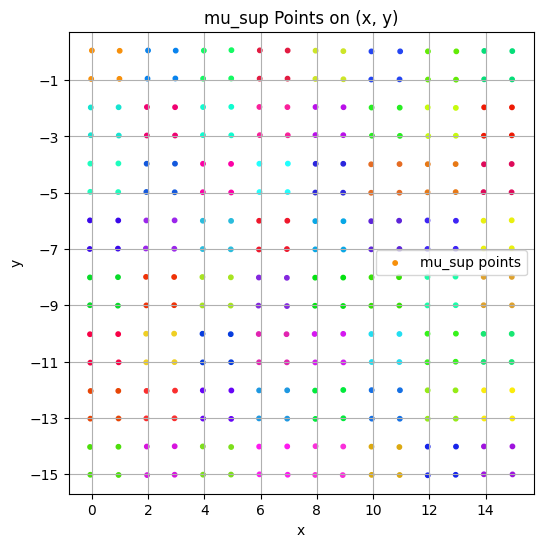

In [ ]:
sup_iterations = 1000  # Number of iterations for the abstraction recovery

for i in range(sup_iterations):
    # Variable update
    varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

    # Unary factor Update
    prior_facs, varis_sup = update_factor(prior_facs_sup, varis_sup, vtof_msgs, linpoints, h3_fn, l2)
    # Binary factor update
    horizontal_facs_sup, varis_sup = update_factor(horizontal_facs_sup, varis_sup, vtof_msgs, 
                                                    linpoints, h4_fn, l2)
    vertical_facs_sup, varis_sup = update_factor(vertical_facs_sup, varis_sup, vtof_msgs, 
                                                    linpoints, h5_fn, l2)

    # Variable update
    varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

b = varis_sup.belief.mu().reshape (64,4,2)
b = b.reshape(-1,2)

plt.figure(figsize=(6, 6))
plt.scatter(b[:, 0], b[:, 1], c=point_colors, label='mu_sup points', s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-2, 16)
plt.ylim(-16, 2)
plt.xticks(range(-2, 16, 2))
plt.yticks(range(-16, 2, 2))
plt.title("mu_sup Points on (x, y)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.savefig("1.png", dpi=400)